# Housing Price Prediction
Here I'm going to try using deep learning frameworks to implement neural networks for this prediction.

Some ideas:
1. There is a mix of continuous and categorical columns, so I will separate them and feed into different parts of the model. I will merge the two parts into the final dense layer for prediction.
2. Some continuous variables need log transformation, and then all continuous variables will be normalized.
3. Categorical variables will be fed into an embedding layer

I'll try to implement this using Keras first, and then I'll try a purely Tensorflow implementation just for fun.

## Import stuff

In [1]:
from collections import defaultdict
import datetime
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, Embedding, Reshape, Activation, concatenate, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras import backend as K
%matplotlib inline

/home/kuang/.conda/envs/machine_learning/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preprocessing

In [2]:
# Read the training and test data
TRAIN = pd.read_csv('train.csv')
SUB = pd.read_csv('test.csv')  # for submission

# Get rid of columns with too many (more than 50%) missing values
cols2drop = [col for col in TRAIN.columns if TRAIN[col].isnull().sum() >= 0.5 * len(TRAIN)]
cols2drop.append('Id')
cols2drop.append('Utilities')  # Utilities resulted in bad embedding, so drop it
print("Columns to drop: {}".format(cols2drop))
TRAIN = TRAIN[[col for col in TRAIN.columns if col not in cols2drop]]
SUB_X = SUB[[col for col in SUB.columns if col not in cols2drop]]
TRAIN_X = TRAIN[[col for col in TRAIN.columns if col != 'SalePrice']]
TRAIN_Y = TRAIN['SalePrice']

Columns to drop: ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Id', 'Utilities']


In [3]:
print(TRAIN.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchS

In [4]:
TRAIN.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [11]:
def preprocessing(df, train):
    """Preprocess the data.
    
    Need to do the following steps:
    1. Separate continuous variables from categorical variables
    2. Identify which columns need log transformation
    3. Normalize continuous columns
    4. Turn categorical columns into indices (to input into an embedding layer)
    
    Returns continuous variables, categorical variables, and sales price.
    """
    # Make separate dataframes
    cont = pd.DataFrame()  # continuous columns
    cat = pd.DataFrame()   # categorical columns
        
    # Now go through each column
    for col in df.columns:
        if col in ['LotFrontage', 'LotArea', 'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                  'GrLivArea', 'GarageArea', 'WoodDeckSF', 'EnclosedPorch', 'OpenPorchSF',
                  '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']:
            # these are numerical columns that should be log-transformed
            cont[col] = continuous_transform(df, col, train, apply_log=True)
        elif col in ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath',
                    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                    'Fireplaces', 'GarageYrBlt', 'GarageCars', 'YrSold']:
            # these are numerical columns that will not be log-transformed
            cont[col] = continuous_transform(df, col, train, apply_log=False)
        elif col != 'SalePrice':
            # the rest are all categorical columns
            cat[col] = categorical_encode(df, col)
    return cont, cat

    
def preproc_price(price, price_train):
    """Apply transformation to SalePrice."""
    # sale price
    log_price = np.log(price)
    log_price_train = np.log(price_train)
    log_price = (log_price - log_price_train.mean()) / log_price_train.std()
    return log_price


def invert_price(log_price, log_price_train):
    """Inverse conversion from predicted log(price) to full price."""
    full_price = np.exp(log_price * log_price_train.std() + log_price_train.mean())
    return full_price

    
def categorical_encode(df, col):
    """Turn categorical variables into indices"""
    known_values = TRAIN[col].fillna('NaN').unique()
    indices = dict(zip(known_values, range(len(known_values))))
    mapper = defaultdict(lambda: -1, indices)
    y = df[col].apply(lambda x: mapper[x])
    return y


def continuous_transform(df, col, train, apply_log=False):
    """Transform & scale continuous columns"""
    if apply_log:
        x = np.log(df[col])
        y = np.log(train[col])
    else:
        x = df[col]
        y = train[col]
    z = (x - y.mean()) / y.std()
    z = z.fillna(0.)
    return z

    
def test_skew(x, thresh=0.05):
    """Test if the distribution is significantly skewed. If yes, apply log transformation.
    """
    z, p = stats.skewtest(x[pd.notnull(x)])
    skew = False
    if p <= 0.05:
        skew = True
    return p, skew

# Borrowed from Coursera course Intro to Deep Learning
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

## Splitting train.csv into training and validation set

In [7]:
train_X, val_X, train_Y, val_Y = train_test_split(TRAIN_X, TRAIN_Y, test_size=0.3)
# all_cont, all_cat = preprocessing(TRAIN_X)  # so that we have all possible values in the training set 
train_cont, train_cat = preprocessing(train_X, train_X)
train_price = preproc_price(train_Y, train_Y)
val_cont, val_cat = preprocessing(val_X, train_X)
val_price = preproc_price(val_Y, train_Y)

/home/kuang/.conda/envs/machine_learning/lib/python3.6/site-packages/ipykernel/__main__.py:62: RuntimeWarning: divide by zero encountered in log
/home/kuang/.conda/envs/machine_learning/lib/python3.6/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in log


## Define model architecture
Getting ideas from the following posts:
1. Using functional API to merge layers: https://stackoverflow.com/questions/43196636/how-to-concatenate-two-layers-in-keras
2. Using embedding layers for each categorical feature: https://medium.com/@satnalikamayank12/on-learning-embeddings-for-categorical-data-using-keras-165ff2773fc9

In [14]:
reset_tf_session()

N1 = len(train_cont.columns)
N2 = len(train_cat.columns)
print("N1, N2 = {}, {}".format(N1, N2))
BATCH_SIZE = 32
# first part of model deals with continuous numerical features
input1 = Input(shape=(N1,))

# second part of model deals with categorical features
# For embedding categorical variables, I'm getting ideas from this post:
# https://medium.com/@satnalikamayank12/on-learning-embeddings-for-categorical-data-using-keras-165ff2773fc9
input2_list = []
embed_layers = []
CATCOL_ORDER = train_cat.columns
for col in train_cat.columns:
    input2_list.append(Input(shape=(1,)))
    nunique = train_cat[col].nunique()
    embed_size = int(min(nunique / 2, 50))
    embed_layer = Embedding(nunique+1, embed_size, input_length=1)(input2_list[-1])
    reshape = Reshape(target_shape=(embed_size,))(embed_layer)
    embed_layers.append(reshape)
input_layer = concatenate([input1] + embed_layers, axis=1)
dense1 = Dense(128, activation='relu')(input_layer)
# drop1 = Dropout(0.1)(dense1)
dense2 = Dense(128, activation='relu')(dense1)
final = Dense(1)(dense2)  # linear activation
model = Model(inputs=[input1]+input2_list, outputs=final)
optimizer = SGD(lr=1.e-3)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

model.summary()

N1, N2 = 29, 45
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 1)             0                                            
___________________________________________________________________________

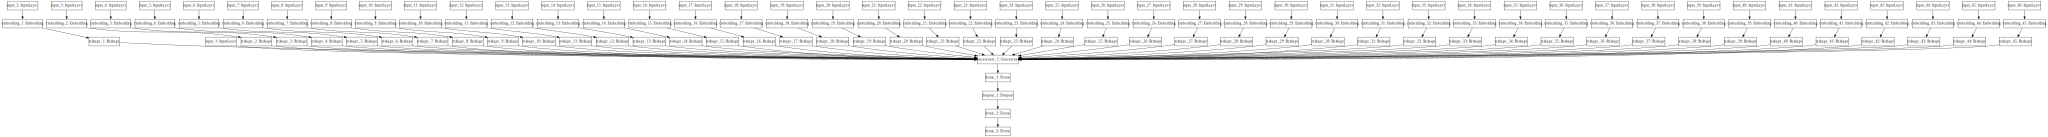

In [9]:
# Visualize the model!
# Instruction taken from https://keras.io/visualization/
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Train on 1022 samples, validate on 438 samples
Epoch 1/100
1022/1022 [==============================] - 1s - loss: 1.1558 - mean_absolute_error: 0.8187 - val_loss: 0.9962 - val_mean_absolute_error: 0.7847
Epoch 2/100
1022/1022 [==============================] - 1s - loss: 1.0034 - mean_absolute_error: 0.7569 - val_loss: 0.8707 - val_mean_absolute_error: 0.7286
Epoch 3/100
1022/1022 [==============================] - 0s - loss: 0.8784 - mean_absolute_error: 0.7018 - val_loss: 0.7657 - val_mean_absolute_error: 0.6782
Epoch 4/100
1022/1022 [==============================] - 1s - loss: 0.7728 - mean_absolute_error: 0.6530 - val_loss: 0.6745 - val_mean_absolute_error: 0.6314
Epoch 5/100
1022/1022 [==============================] - 1s - loss: 0.6793 - mean_absolute_error: 0.6068 - val_loss: 0.5919 - val_mean_absolute_error: 0.5863
Epoch 6/100
1022/1022 [==============================] - 1s - loss: 0.5956 - mean_absolute_error: 0.5629 - val_loss: 0.5180 - val_mean_absolute_error: 0.5436
Epoch

1022/1022 [==============================] - 1s - loss: 0.1321 - mean_absolute_error: 0.2501 - val_loss: 0.1152 - val_mean_absolute_error: 0.2522
Epoch 53/100
1022/1022 [==============================] - 1s - loss: 0.1314 - mean_absolute_error: 0.2497 - val_loss: 0.1148 - val_mean_absolute_error: 0.2516
Epoch 54/100
1022/1022 [==============================] - 1s - loss: 0.1309 - mean_absolute_error: 0.2486 - val_loss: 0.1144 - val_mean_absolute_error: 0.2511
Epoch 55/100
1022/1022 [==============================] - 1s - loss: 0.1302 - mean_absolute_error: 0.2482 - val_loss: 0.1140 - val_mean_absolute_error: 0.2506
Epoch 56/100
1022/1022 [==============================] - 0s - loss: 0.1296 - mean_absolute_error: 0.2472 - val_loss: 0.1136 - val_mean_absolute_error: 0.2502
Epoch 57/100
1022/1022 [==============================] - 0s - loss: 0.1291 - mean_absolute_error: 0.2469 - val_loss: 0.1133 - val_mean_absolute_error: 0.2496
Epoch 58/100
1022/1022 [==============================] - 1

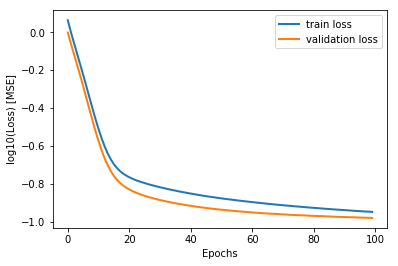

In [15]:
input_train_cat = [train_cat[col].values.reshape([len(train_cat), 1]) for col in train_cat.columns]
input_val_cat = [val_cat[col].values.reshape([len(val_cat), 1]) for col in train_cat.columns]

out = model.fit(x=[train_cont.values]+input_train_cat,
                y=train_price.values,
                epochs=100,
                validation_data=[[val_cont.values]+input_val_cat, val_price.values])

# Plot training and validation losses over epochs
plt.plot(np.log10(out.history['loss']), lw=2, label='train loss')
plt.plot(np.log10(out.history['val_loss']), lw=2, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('log10(Loss) [MSE]')
plt.legend(loc=0)

## Prepare submission

In [54]:
sub_cont, sub_cat = preprocessing(SUB_X, train_X)
input_sub_cat = [sub_cat[col].values.reshape([len(sub_cat), 1]) for col in sub_cat.columns]

sub_log_price = model.predict([sub_cont.values]+input_sub_cat)
sub_price = invert_price(sub_log_price, np.log(train_Y)).ravel()
pred = pd.DataFrame(data={'Id': SUB['Id'], 'SalePrice': sub_price})
timestamp = datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d-%H%M')
pred.to_csv('Submission-{0}.csv'.format(timestamp), index=False)

/home/kuang/.conda/envs/machine_learning/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log
/home/kuang/.conda/envs/machine_learning/lib/python3.6/site-packages/ipykernel/__main__.py:62: RuntimeWarning: divide by zero encountered in log
